### **Variational Physics Informed Neural Network**

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch import optim
from numpy.polynomial import legendre as leg
from scipy.integrate import quad
from scipy.linalg import eigh
from scipy.interpolate import UnivariateSpline

In [2]:
style = "clean.mplstyle"

In [3]:
def style_plot(x, y, x_data, y_data, yh, i, xp=None):
    style = "clean.mplstyle"
    with plt.style.context(style):        
        fig = plt.figure()
        ax = plt.subplot(111)
        plt.plot(x, y, label="Exact solution")
        if y_data is not None:            
            plt.scatter(x_data, y_data, label='Training data')
        if yh is not None:
            plt.scatter(x, yh, label="Neural network prediction", s=10, color='#377eb8')
        if xp is not None:
            plt.scatter(xp, -0*torch.ones_like(xp), label='Physics loss training locations', marker='.', s=6)
        plt.annotate("Training step: %i"%(i+1), 
             xy=(0, 1), 
             xycoords='axes fraction', 
             fontsize="small", 
             color="k",
             ha='left', 
             va='top')
        plt.legend(loc='best')
        plt.xlabel(r'$x$')
        plt.ylabel(r'$u(x)$')

**Funciones de Test con FEM Helmholtz**

In [4]:
def FEM1D(coords):
    N = len(coords)
    stiff_loc = np.array([[2.0, -2.0],
                          [-2.0, 2.0]])
    mass_loc = np.array([[2/3, 1/3],
                         [1/3, 2/3]])
    eles = [np.array([cont, cont + 1]) for cont in range(0, N - 1)]
    stiff = np.zeros((N, N))
    mass = np.zeros((N, N))
    for ele in eles:  ## Ensamblaje
        jaco = coords[ele[1]] - coords[ele[0]]
        for cont1, row in enumerate(ele):
            for cont2, col in enumerate(ele):
                stiff[row, col] = stiff[row, col] +  stiff_loc[cont1, cont2]/jaco
                mass[row, col] = mass[row, col] +  jaco*mass_loc[cont1, cont2]
    return stiff, mass

# Caso de ejemplo
N = 1000
nvals = 10
x = np.linspace(0, 1, N)

# FEM1D
stiff, mass = FEM1D(x)

# Vectores propios
vals, vecs = eigh(stiff[1:-1, 1:-1],
                  mass[1:-1, 1:-1],
                  subset_by_index=(0, nvals - 1))

vecs_comp = np.zeros((N, nvals))
vecs_comp[1:-1, :] = vecs

# Interpolación
x_eval = torch.linspace(0, 1, N).detach().numpy()
spline = UnivariateSpline(x, vecs_comp[:, 2], s=0, k=1)
v_eval = spline(x_eval)
v_eval = v_eval.reshape(N, 1)
#
#spline_derivative = spline.derivative()
#v_eval_derivative = spline_derivative(x)

In [ ]:
v_test = torch.zeros(N, nvals)
v_dv = torch.zeros(N, nvals)
for i in range(vecs_comp.shape[1]):
    spline_mode = UnivariateSpline(x, vecs_comp[:, i], s=0, k=1)
    v_mode = spline_mode(x)  
    v_mode = v_mode.reshape(N, 1)  
    print(v_mode.shape)

    v_test[:, i] = torch.tensor(v_mode).squeeze()
    v_dv[:, i] = torch.tensor(spline_mode.derivative()(x)).squeeze()

v_test.shape, v_dv.shape

(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)


(torch.Size([1000, 10]), torch.Size([1000, 10]))

**Arquitectura de Red Neuronal**

In [5]:
class FCN(nn.Module):  
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
            nn.Linear(N_INPUT, N_HIDDEN),
            activation()])
        self.fch = nn.Sequential(*[
                    nn.Sequential(*[
                        nn.Linear(N_HIDDEN, N_HIDDEN),
                        activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        a = x * (x - torch.pi)
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)        
        output = torch.einsum('ij,ij->ij', a, x)
        return output

In [19]:
import torch.nn.functional as F
class CNNPDE(nn.Module):
    def __init__(self):
        super(CNNPDE, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        a = x * (x - torch.pi)
        x = x.unsqueeze(1)  
        x = torch.tanh(self.conv1(x))
        x = torch.tanh(self.conv2(x))
        x = F.avg_pool1d(x, x.size()[2])        
        x = x.permute(0, 2, 1)  
        output = self.fc(x)
        output = torch.einsum('ij,ij->ij', a, output.squeeze(1))
        return output

In [23]:
class RNNPDE(nn.Module):
    def __init__(self):
        super(RNNPDE, self).__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=10, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Sequential(
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        a = x * (x - torch.pi)
        x = x.unsqueeze(2)  
        out, _ = self.rnn(x) 
        out = out[:, -1, :]  
        out = self.fc(out) 
        out = torch.einsum('ij,ij->ij', a, out)
        return out  

In [8]:
class TransformerEDP(nn.Module):    
    def __init__(self, input_dim, output_dim, num_layers, hidden_dim):
        super(TransformerEDP, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh()
        )
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=1, activation='relu'), 
            num_layers
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):  
        a = x * (x - torch.pi)      
        x = self.encoder(x)  
        output = self.transformer_encoder(x)  
        output = self.decoder(output)
        out = torch.einsum('ij,ij->ij', a, output)
        return output 

Formulación problema

In [9]:
def f_rhs(x):
  return 0.*x-2. #4*torch.sin(2 * x) # #

def exact_u(x):
  return x*(x-torch.pi) # #torch.sin(2 * x) #

**Variational Neural Network**

Variational Loss

Loss at iteration 20: 3.665466547012329
Loss at iteration 40: 5.212302207946777
Loss at iteration 60: 1.814978957176208
Loss at iteration 80: 0.565270066261292
Loss at iteration 100: 0.431324958801270
Loss at iteration 120: 0.240705549716949
Loss at iteration 140: 0.205029428005219
Loss at iteration 160: 0.398520439863205
Loss at iteration 180: 0.161419600248337
Loss at iteration 200: 0.056293811649084
Loss at iteration 220: 0.170046180486679
Loss at iteration 240: 0.142477169632912
Loss at iteration 260: 0.059849064797163
Loss at iteration 280: 0.205467998981476
Loss at iteration 300: 0.092333540320396
Loss at iteration 320: 0.115591578185558
Loss at iteration 340: 0.114943526685238
Loss at iteration 360: 0.110210284590721
Loss at iteration 380: 0.104090586304665
Loss at iteration 400: 0.129137411713600
Loss at iteration 420: 0.055221214890480


C:\Users\Juan Pablo\AppData\Local\Temp\ipykernel_352720\2790318469.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


Loss at iteration 440: 0.120229385793209
Loss at iteration 460: 0.066919423639774
Loss at iteration 480: 0.051370300352573
Loss at iteration 500: 0.082929477095604
Loss at iteration 520: 0.038062300533056
Loss at iteration 540: 0.025660829618573
Loss at iteration 560: 0.054864499717951
Loss at iteration 580: 0.075021855533123
Loss at iteration 600: 0.066057339310646
Loss at iteration 620: 0.018560418859124
Loss at iteration 640: 0.092506386339664
Loss at iteration 660: 0.041200697422028
Loss at iteration 680: 0.077851474285126
Loss at iteration 700: 0.059983793646097
Loss at iteration 720: 0.026859978213906
Loss at iteration 740: 0.035574618726969
Loss at iteration 760: 0.050090163946152
Loss at iteration 780: 0.056645411998034
Loss at iteration 800: 0.035282328724861
Loss at iteration 820: 0.036592297255993
Loss at iteration 840: 0.019169855862856
Loss at iteration 860: 0.018969450145960
Loss at iteration 880: 0.044106986373663
Loss at iteration 900: 0.029357556253672
Loss at iteratio

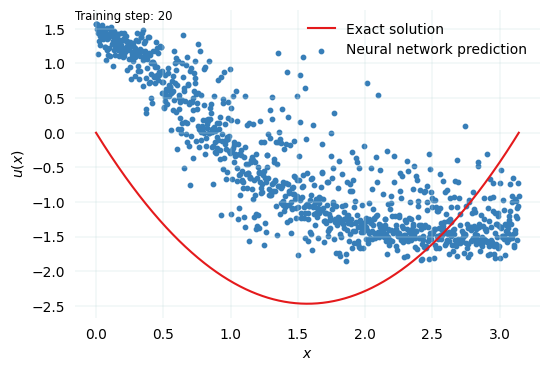

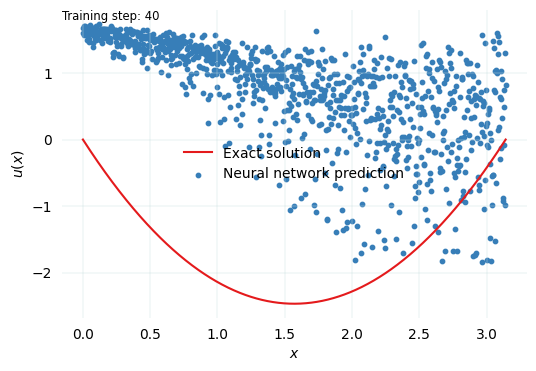

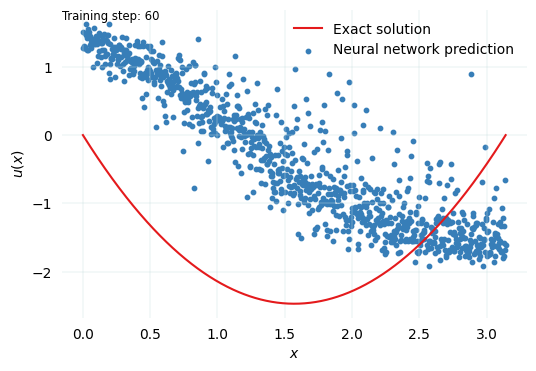

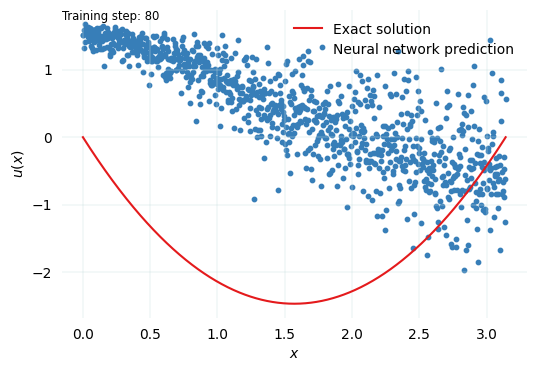

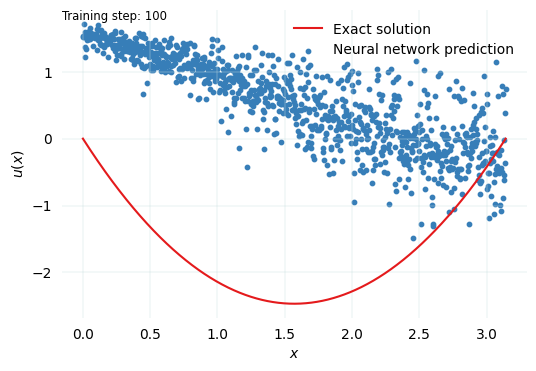

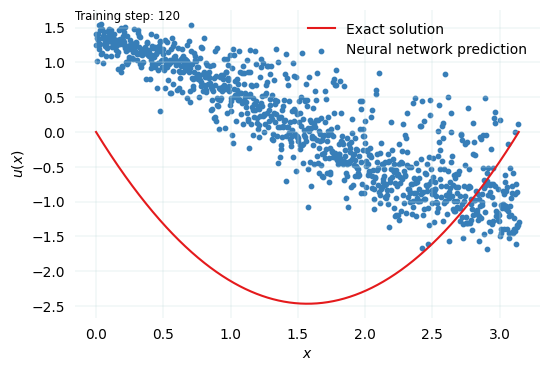

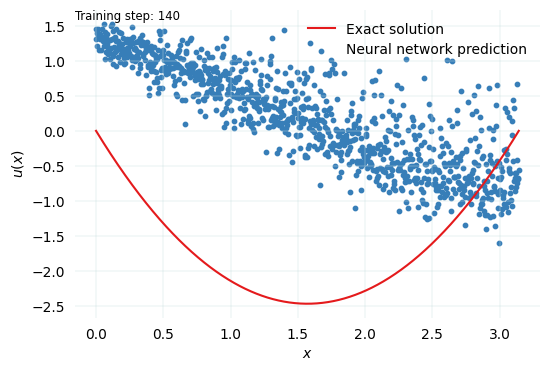

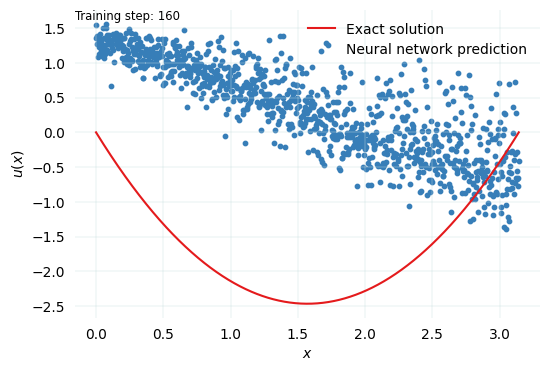

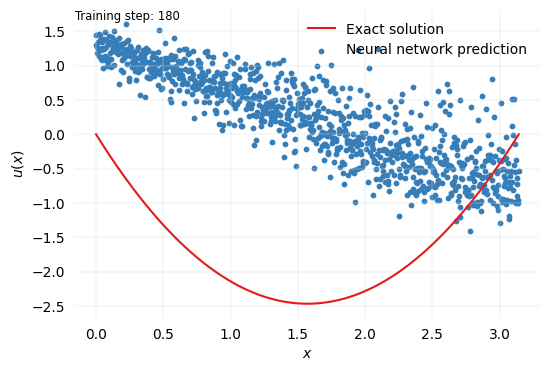

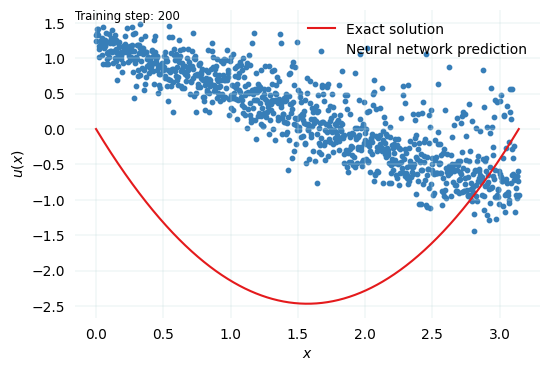

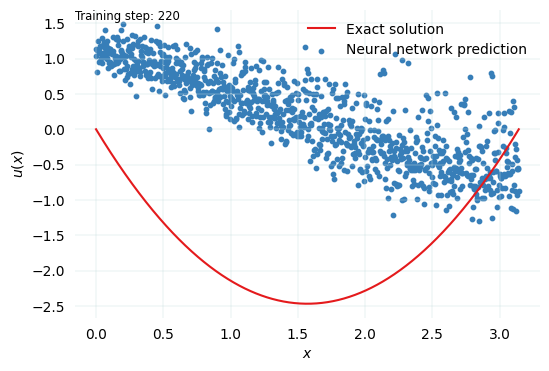

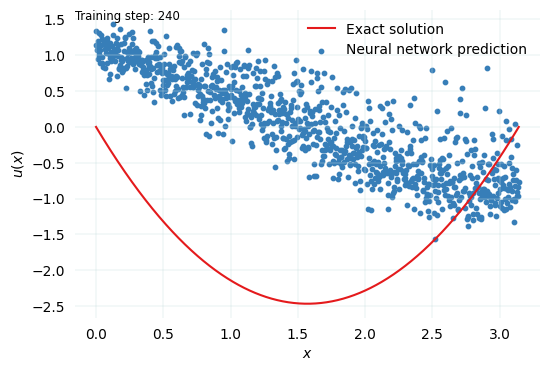

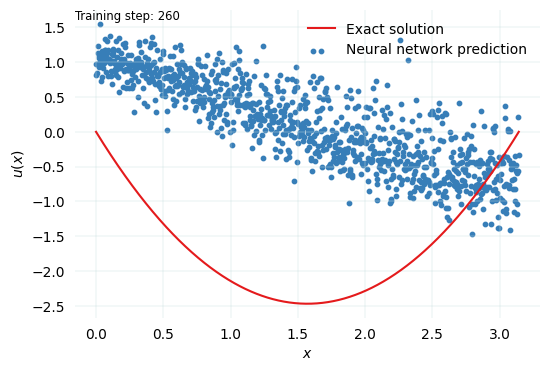

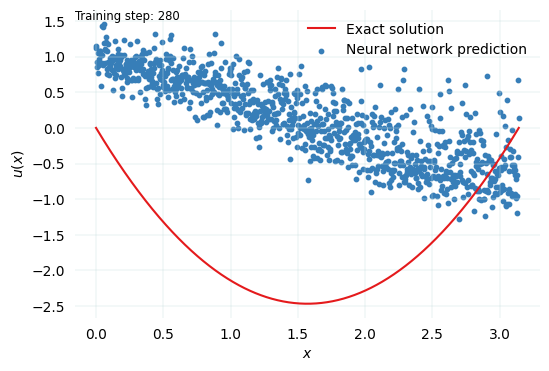

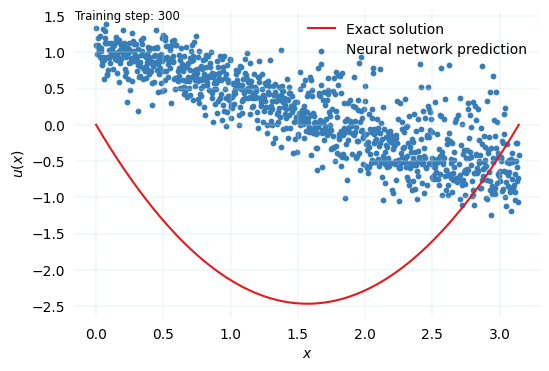

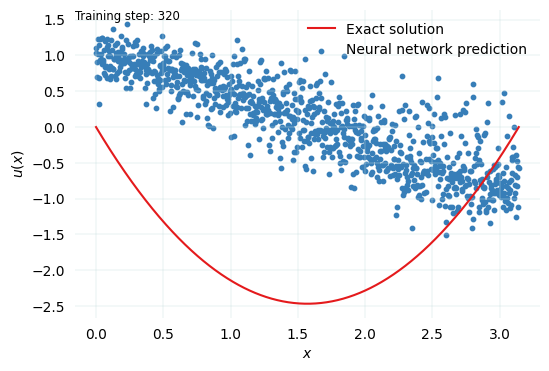

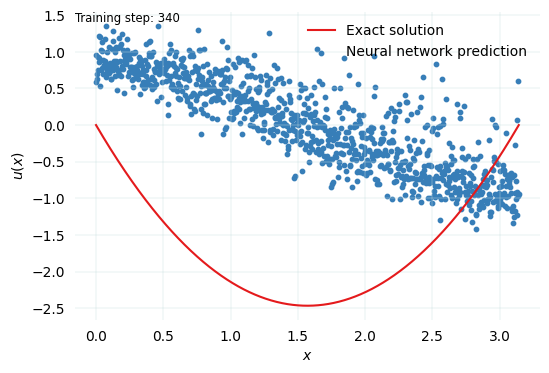

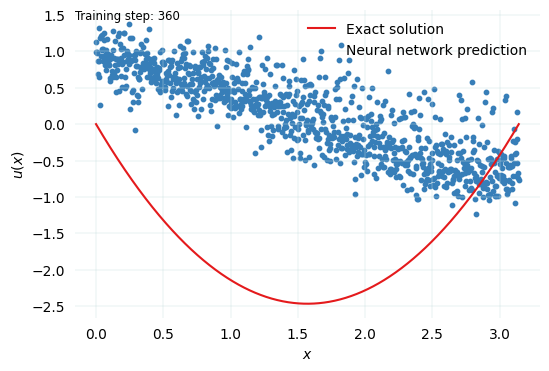

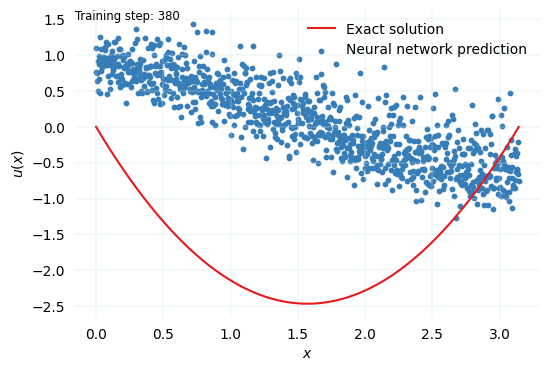

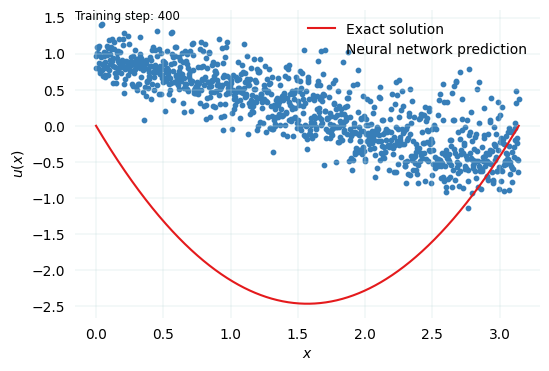

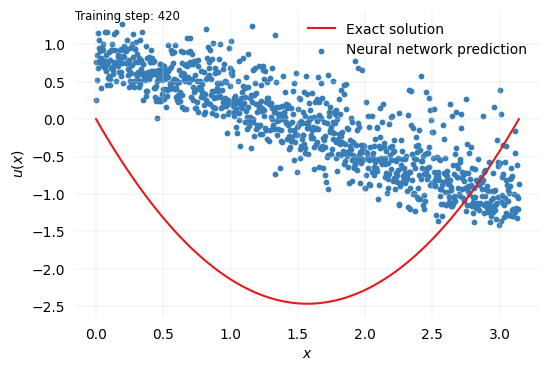

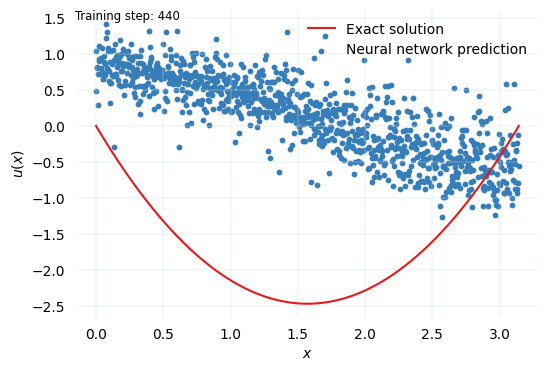

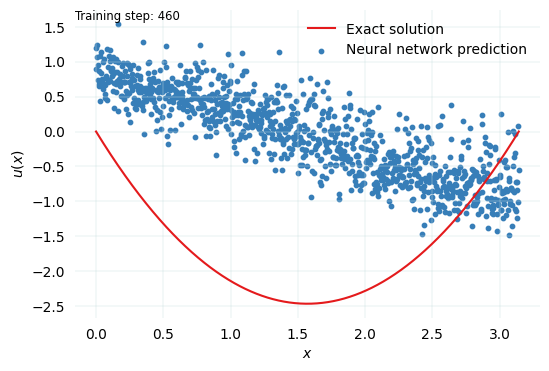

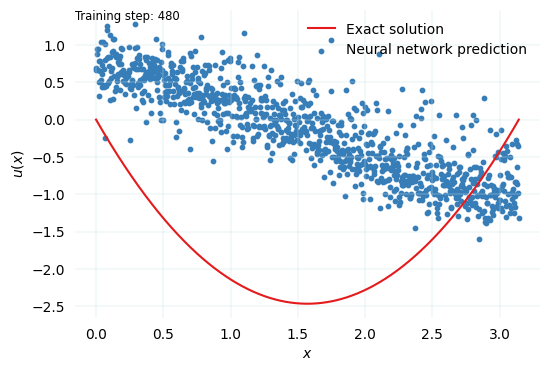

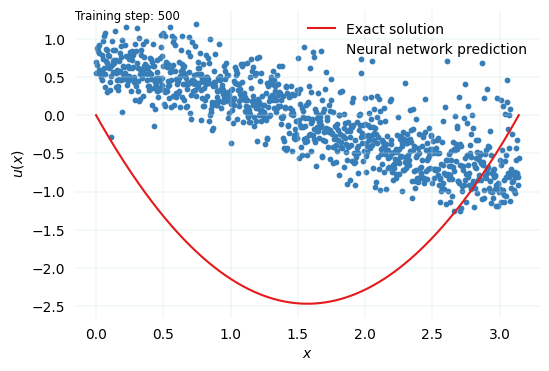

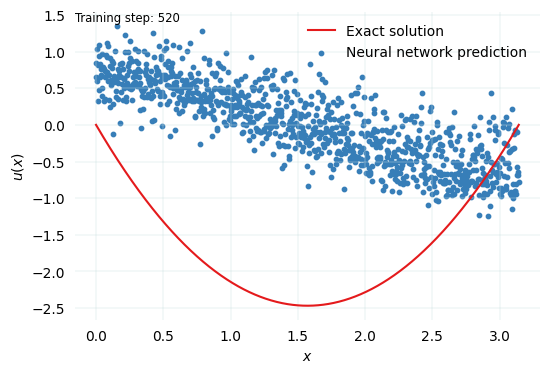

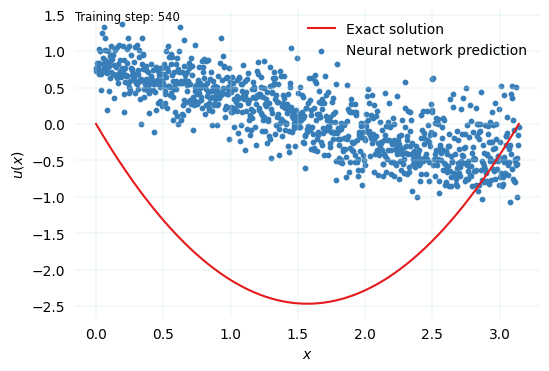

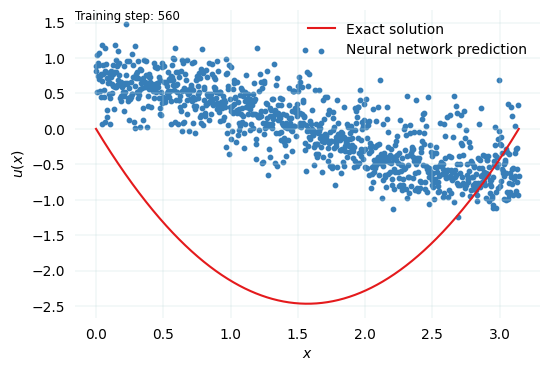

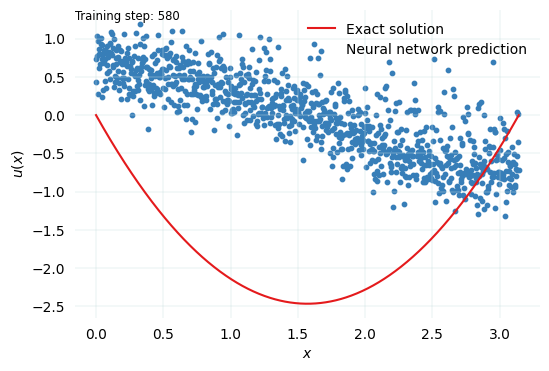

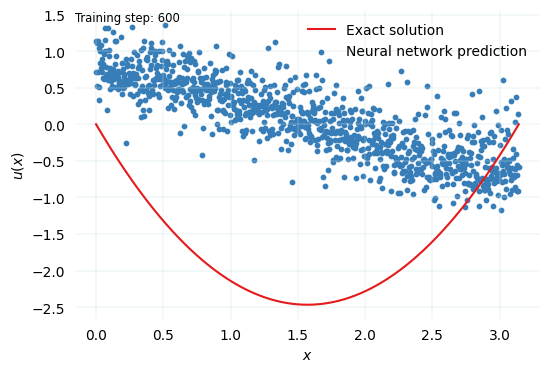

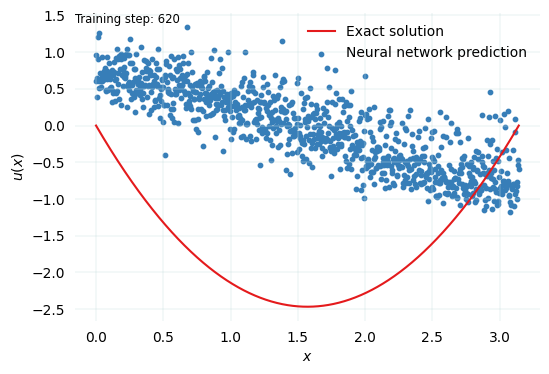

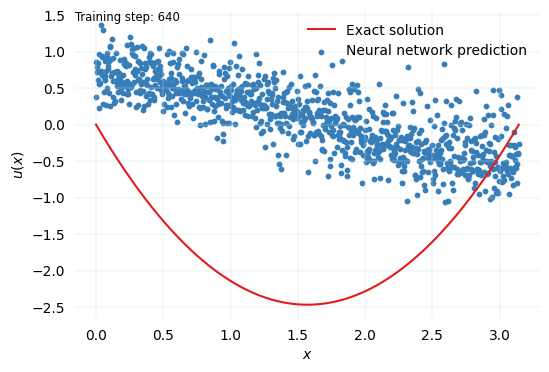

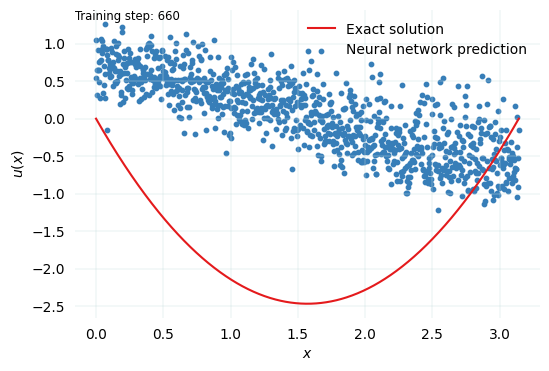

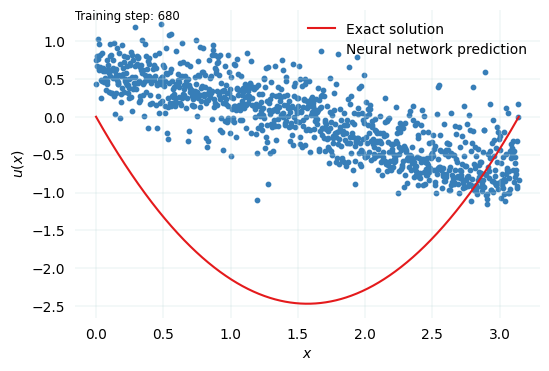

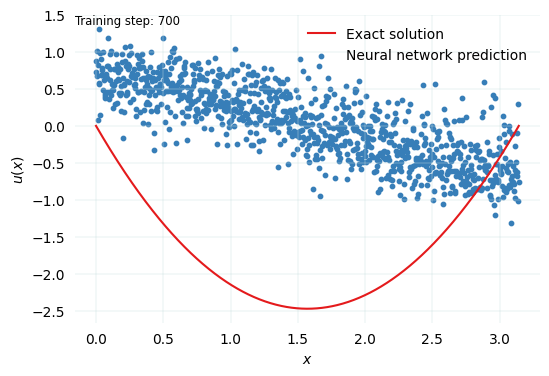

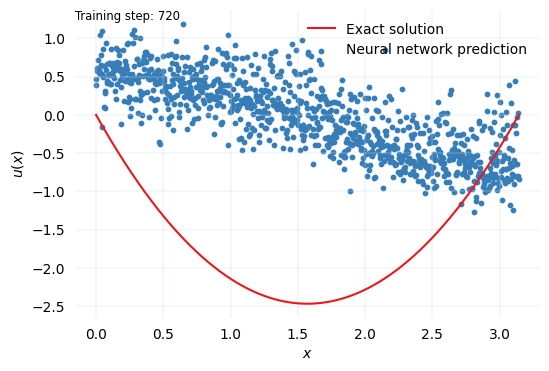

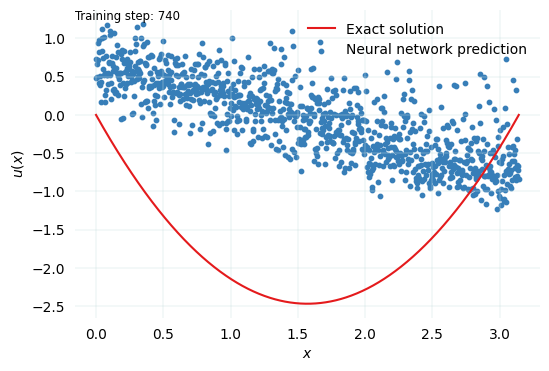

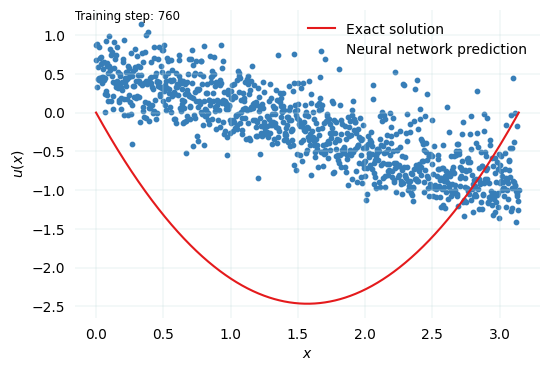

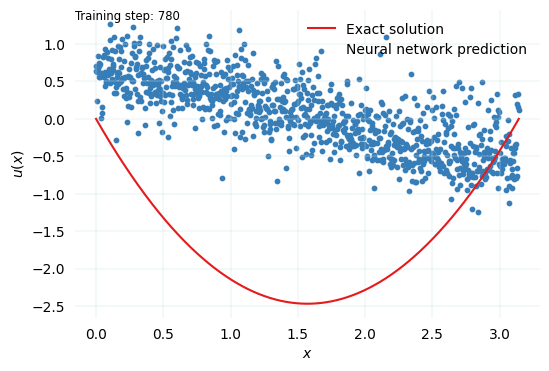

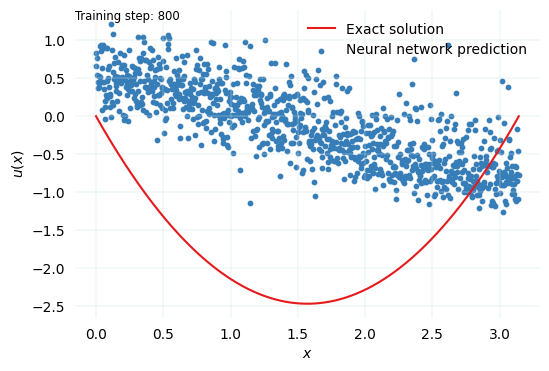

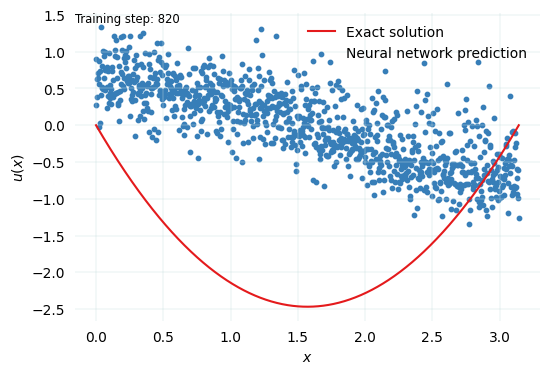

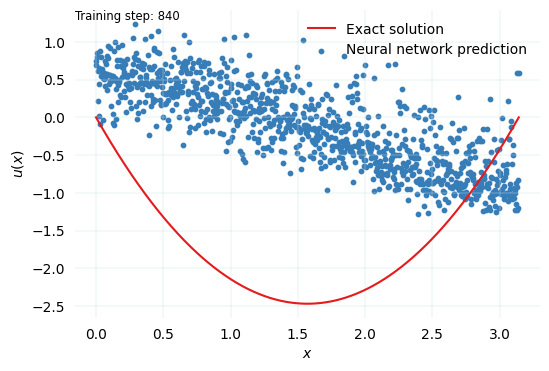

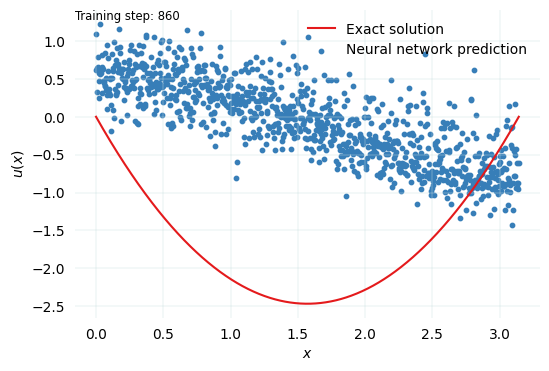

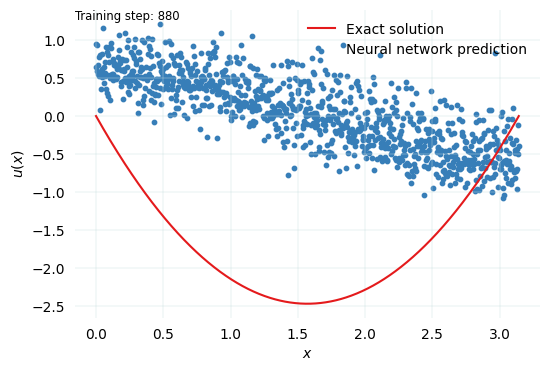

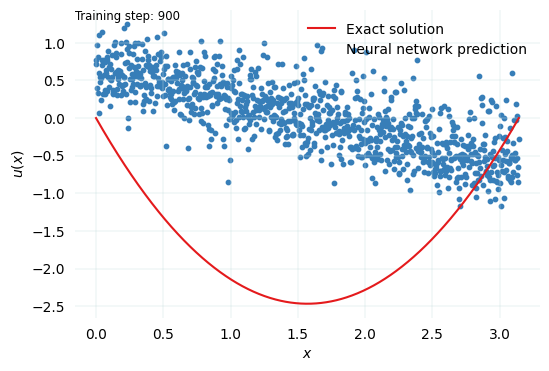

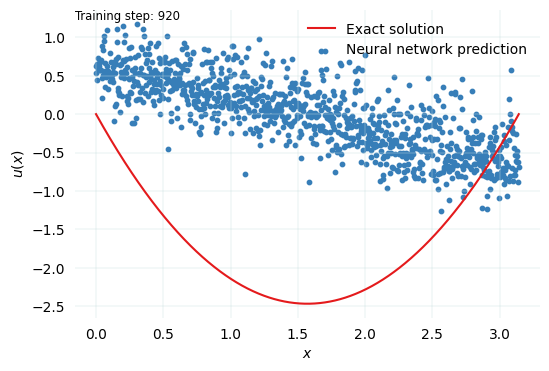

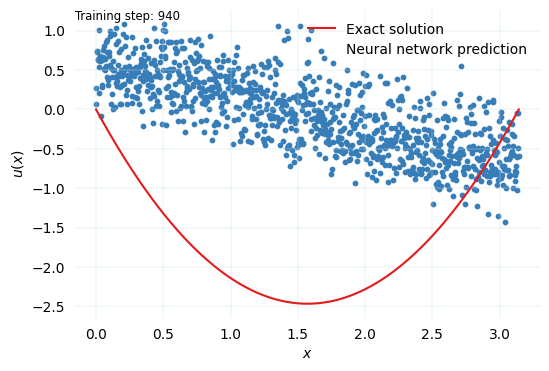

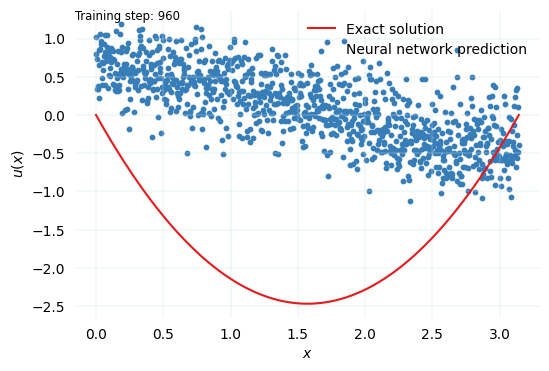

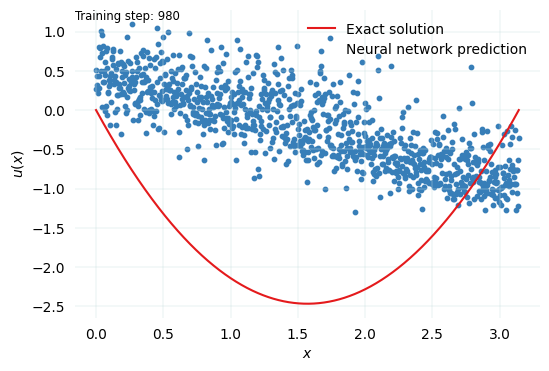

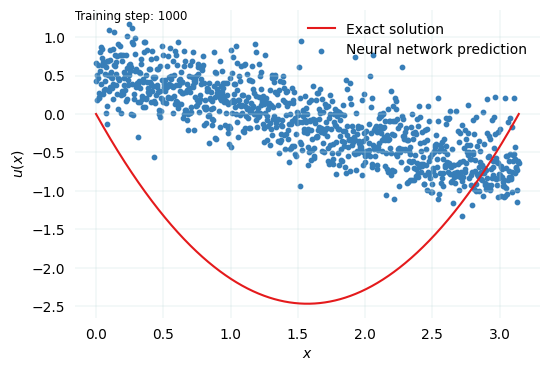

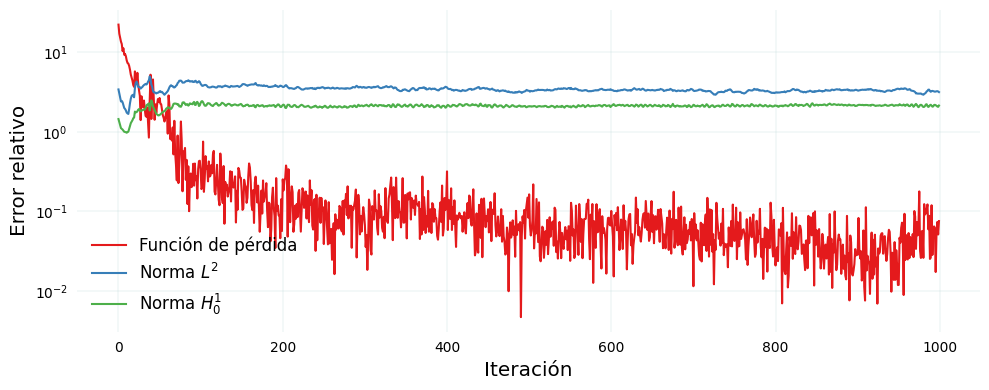

In [26]:
def compute_integral(y, x):    
    integral = torch.trapz(y, x, dim=0)
    return integral

def exact_u_prime(x):
    return 2*x - torch.pi

def compute_loss(model, x, v, v_dv):
    u = model(x)
    du = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True, retain_graph=True)[0]     
    
    dvs = v_dv
        
    f_rhs_val = f_rhs(x)    
    #integral_left = compute_integral(torch.einsum('jl,kjl->jk', du, dvs),x)    BUENO SINS FUNCS
    integral_left = compute_integral(torch.einsum('ij,ij->ij', du, dvs), x) # PRUEBA HELMHOLTZ
    integral_right = compute_integral(torch.einsum('jl,jk->jk', f_rhs_val, v), x)

    error_PDE = (integral_left - integral_right)**2    
    loss = error_PDE.sum()    

    return loss

def compute_errors(model, x, exact_u):
    exact_function = exact_u(x)
    predicted_function = model(x)

    error_between_functions = exact_function - predicted_function
    error_squared = error_between_functions**2
    L2_error = compute_integral(error_squared, x)

    predicted_derivative = torch.autograd.grad(predicted_function, x, torch.ones_like(predicted_function), create_graph=True, retain_graph=True)[0]
    exact_derivative = exact_u_prime(x)
    error_between_derivatives = exact_derivative - predicted_derivative
    error_derivative_squared = error_between_derivatives**2

    H1_error = compute_integral(error_squared + error_derivative_squared, x)
    
    exact_function_squared = exact_function**2
    exact_function_norm = compute_integral(exact_function_squared, x)
    
    H01_error = compute_integral(error_derivative_squared, x) 

    relative_H1_error = H1_error / exact_function_norm

    return torch.sqrt(L2_error).item(), torch.sqrt(relative_H1_error).item() #torch.sqrt(relative_H1_error).item()

def main():
    N_modes = 20
    n_pts = 1000
    iterations = 1000

    torch.manual_seed(123)
    model = TransformerEDP(1, 1, 2, 10)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    losses = []
    L2_errors = []    
    h1_norms = []      

    n = torch.linspace(1, N_modes, N_modes)     

    for i in range(iterations):        
        x = torch.linspace(0, np.pi, n_pts)        
        
        # Funciones de test - vectores propios Helmholtz        
        v_test = torch.zeros(n_pts, N_modes)
        v_dv = torch.zeros(n_pts, N_modes)
        for j in range(vecs_comp.shape[1]):
            spline_mode = UnivariateSpline(x, vecs_comp[:, j], s=0, k=1)
            v_mode = spline_mode(x)  
            v_mode = v_mode.reshape(n_pts, 1)              
            v_test[:, j] = torch.tensor(v_mode).squeeze()
            v_dv[:, j] = torch.tensor(spline_mode.derivative()(x)).squeeze()            

        x = x.requires_grad_(True).view(n_pts, 1)              
        
        v = v_test
        dvs = v_dv
    
        optimizer.zero_grad()

        loss = compute_loss(model, x, v, dvs)        
        loss.backward(retain_graph=True)
        optimizer.step()                   

        losses.append(loss.item())
        L2_error, H1_norm = compute_errors(model, x, exact_u)
        L2_errors.append(L2_error)
        h1_norms.append(H1_norm)
        if (i+1) % 20 == 0:
            print(f"Loss at iteration {i+1}: {loss.item():.15f}")  
               
            x_test = torch.linspace(0, np.pi, n_pts).view(n_pts, 1)
            y_test = model(x_test).detach().numpy()    
            y_real = exact_u(x_test).detach().numpy() 
            style_plot(x_test, y_real, x_data=None, y_data=None, yh=y_test, i=i)   
            plt.savefig(f'plots/vpinn_{i+1}.pdf', dpi=300, bbox_inches='tight')    

    with plt.style.context(style):        
        fig, ax = plt.subplots(figsize=(10, 4))

        # Graficar la función de pérdida en escala semilog
        ax.semilogy(losses, label="Función de pérdida")

        # Graficar el error L2 en escala semilog en la misma gráfica
        ax.semilogy(L2_errors, label="Norma $L^2$")       

        ax.semilogy(h1_norms, label="Norma $H_0^1$")         

       
        ax.set_xlabel("Pérdida", fontsize="x-large")  # Etiqueta del eje x
        ax.set_ylabel("Norma $H_0^1$", fontsize="x-large")  # Etiqueta del eje y

        # Configurar los títulos y etiquetas    
        ax.set_xlabel("Iteración", fontsize="x-large")  # Cambiar a "x-large"
        ax.set_ylabel('Error relativo', fontsize="x-large")  # Cambiar a "x-large"
        ax.legend(fontsize="large")

        # Ajustar el layout y mostrar la figura
        plt.tight_layout()
        plt.savefig('combined_semilog_plot.pdf', dpi=300, bbox_inches='tight')
        plt.show()
    
    x_test = torch.linspace(0, np.pi, n_pts).view(n_pts, 1)
    y_test = model(x_test).detach().numpy()    
    y_real = exact_u(x_test).detach().numpy()      
if __name__ == "__main__":
    main()

### **Optimización de hiperparámetros**

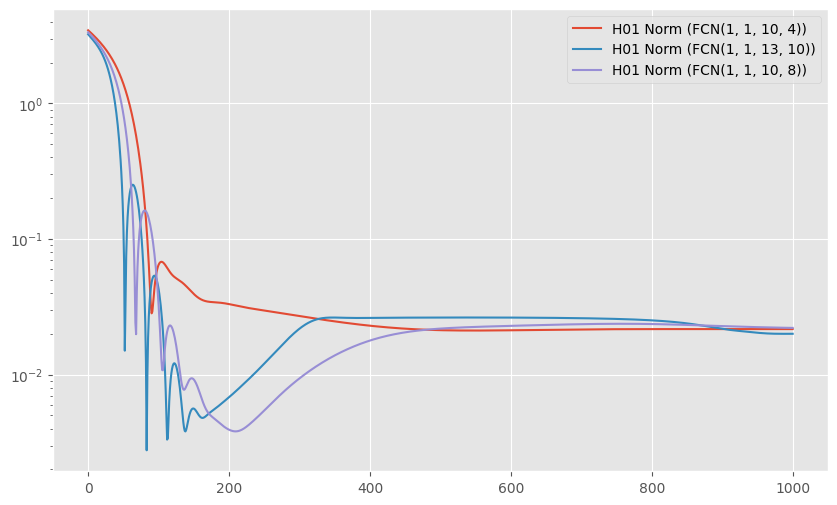

In [19]:
import matplotlib.pyplot as plt

def train_model(model, iterations):
    N_modes = 20
    n_pts = 1000
    iterations = 1000
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    losses = []
    L2_errors = []    
    h1_norms = []      

    for i in range(iterations):        
        # ... (código para generar los datos de entrada y las funciones de test) ...
        x = torch.linspace(0, np.pi, n_pts)        
        
        # Funciones de test - vectores propios Helmholtz        
        v_test = torch.zeros(n_pts, N_modes)
        v_dv = torch.zeros(n_pts, N_modes)
        for j in range(vecs_comp.shape[1]):
            spline_mode = UnivariateSpline(x, vecs_comp[:, j], s=0, k=1)
            v_mode = spline_mode(x)  
            v_mode = v_mode.reshape(n_pts, 1)              
            v_test[:, j] = torch.tensor(v_mode).squeeze()
            v_dv[:, j] = torch.tensor(spline_mode.derivative()(x)).squeeze()            

        x = x.requires_grad_(True).view(n_pts, 1)   
        
        # Funciones test sin funcs
        #v = torch.sin(torch.einsum('jk,i->ji', x, n))         
        
        v = v_test
        dvs = v_dv
    
        optimizer.zero_grad()

        loss = compute_loss(model, x, v, dvs)        
        loss.backward(retain_graph=True)
        optimizer.step()                         

        losses.append(loss.item())
        L2_error, H1_norm = compute_errors(model, x, exact_u)
        L2_errors.append(L2_error)
        h1_norms.append(H1_norm)

    return losses, L2_errors, h1_norms


# Crear y entrenar la primera red neuronal
model1 = FCN(1, 1, 10, 4)
losses1, L2_errors1, h1_norms1 = train_model(model1, 1000)

# Crear y entrenar la segunda red neuronal
model2 = FCN(1, 1, 13, 10)
losses2, L2_errors2, h1_norms2 = train_model(model2, 1000)

# Crear y entrenar la tercera red neuronal
model3 = FCN(1, 1, 10, 8)
losses3, L2_errors3, h1_norms3 = train_model(model3, 1000)

# Crear la gráfica
plt.figure(figsize=(10, 6))

# Añadir las métricas de la primera red neuronal a la gráfica
#plt.semilogy(losses1, label='Loss (FCN(1, 1, 10, 4))')
#plt.semilogy(L2_errors1, label='L2 Error (FCN(1, 1, 10, 4))')
plt.semilogy(h1_norms1, label='H01 Norm (FCN(1, 1, 10, 4))')

# Añadir las métricas de la segunda red neuronal a la gráfica
#plt.semilogy(losses2, label='Loss (FCN(1, 1, 13, 10))')
#plt.semilogy(L2_errors2, label='L2 Error (FCN(1, 1, 13, 10))')
plt.semilogy(h1_norms2, label='H01 Norm (FCN(1, 1, 13, 10))')

# Añadir las métricas de la tercera red neuronal a la gráfica
#plt.semilogy(losses3, label='Loss (FCN(1, 1, 10, 8))')
#plt.semilogy(L2_errors3, label='L2 Error (FCN(1, 1, 10, 8))')
plt.semilogy(h1_norms3, label='H01 Norm (FCN(1, 1, 10, 8))')

# Añadir una leyenda y mostrar la gráfica
plt.legend()
plt.show()

In [15]:
n = torch.arange(1, 1000 + 1).float()
test_funcs = lambda x: torch.sin(torch.pi * n.view(-1, 1) * x)
v = test_funcs(x)
v

tensor([[ 0.0000e+00,  3.1447e-03,  6.2894e-03,  ...,  6.2893e-03,
          3.1446e-03, -8.7423e-08],
        [ 0.0000e+00,  6.2894e-03,  1.2579e-02,  ..., -1.2578e-02,
         -6.2893e-03,  1.7485e-07],
        [ 0.0000e+00,  9.4341e-03,  1.8867e-02,  ...,  1.8867e-02,
          9.4340e-03, -2.3850e-08],
        ...,
        [ 0.0000e+00,  3.1446e-03, -6.2892e-03,  ...,  6.3913e-03,
         -3.2467e-03,  1.0203e-04],
        [ 0.0000e+00, -1.1105e-07,  2.2210e-07,  ..., -1.1072e-04,
          1.1083e-04, -1.1094e-04],
        [ 0.0000e+00, -3.1449e-03,  6.2897e-03,  ..., -6.1698e-03,
          3.0250e-03,  1.1985e-04]], dtype=torch.float64)

In [ ]:
#def compute_L2_error(model, x, exact_u):
#    exact_function = exact_u(x)
#    predicted_function = model(x)
#
#    error_between_arrays = (exact_function - predicted_function)**2
#    L2_error = compute_integral(error_between_arrays, x)
#
#    error_between_functions = exact_function - predicted_function    
#    
#    error_derivative = torch.autograd.grad(error_between_functions, x, torch.ones_like(error_between_functions), create_graph=True, retain_graph=True)[0]
#        
#    norm_H1_error = compute_integral(error_derivative**2, x)
#    norm_H1_error = torch.sqrt(norm_H1_error**2 + L2_error**2)
#
#    return torch.sqrt(L2_error).item(), norm_H1_error.item()